# Downloaded from Kaggle Dataset
https://www.kaggle.com/bigironsphere/simple-molecular-geometry-features/downloads/simple-molecular-geometry-features.zip/1

![](https://www.biotage.com/uploads/photos/2013_web_banners5.jpg)


# Molecular Geometry Feature Engineering
---

The shape of molecules is principally related to the quantum mechanical properties of electron interactions. Electron interaction also mediates the strength of the nuclear coupling constant between bound atoms, so features derived from their 3D distribution may prove useful.

This kernel uses Singular Value Decomposition (SVD) to calculate the 2D plane of best fit for all molecules containing 4 or more atoms, and then calculates both the mean normalised distance of all atoms from this plane to provide a measure of 'flatness' for the molecule. The angles subtended by this plane and the atomic bonds in the molecule are then calculated.

Some caution should be used with the latter feature. Molecules without a clear 2D plane of best fit - tetrahedral structures like methane for example - may yield angle measurements that are not informative. You may want to experiment and use a threshold of molecular 'flatness' above which angle measurements are discarded. I have calculated flatness in such a way that 0 represents a totally flat molecule. Molecules comprising 3 atoms or fewer are always flat so this measure is not informative for them; I have filled in these values with `np.nan`.

This kernel also performs a simple PCA with SVD to extract the principal axis of each molecule, along with the angle subtended by each bond with it. This can be done with molecules of at least 3 atoms. Again, molecules without a clear orientation may yield arbitrary results; however, this kernel contains plenty of ideas to get you started. These features take a long time to process, around 12 hours in total. I'm putting the finished file into a dataset so check in the comments section for a link if you don't want to engineer them yourself.

I'll be using the visualisation library demonstrated in [this excellent kernel](https://www.kaggle.com/borisdee/how-to-easy-visualization-of-molecules) to show some feature examples. 

In [2]:
!pip install ase

    100% |████████████████████████████████| 1.8MB 8.4MB/s 
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import math
from numpy.linalg import svd
import ase
from ase import Atoms
import ase.visualize
import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [5]:
print(train.shape)

(4658147, 6)


In [6]:
print(test.shape)

(2505542, 5)


# Parallelize - by Rob

In [37]:
size_list = []
flatness = []
bond_angle_plane = []
bond_angle_axis = []

molecule_names_test = np.unique(test.molecule_name.values.flatten())
molecule_names_train = np.unique(train.molecule_name.values.flatten())

def calculate_angles(molecule_name):  
    size_list = []
    flatness = []
    bond_angle_plane = []
    bond_angle_axis = []
    mol = molecule_name
    #obtain structure and bond information for each molecule
    temp_struct = struct.loc[struct.molecule_name==mol, :]
    #bonds = test.loc[test.molecule_name == mol, :]
    tt = pd.concat([train, test], axis=0)
    bonds = tt.loc[tt.molecule_name == mol, :]
    #number of constituent atoms
    size = len(temp_struct)
    size_list.extend(np.full(len(bonds), size))
    
    #nuclei coords
    coords = np.column_stack([temp_struct.x.values,
                                     temp_struct.y.values,
                                     temp_struct.z.values]).T
    
    #principal axis of molecular alignment
    axis_vector = PCA_SVD(coords)
    
    #obtain flatness metric and plane angles for binds if nuclei > 3
    if size > 3:
        
        coords = coords - coords.mean()
        #calculate best fitting 2D plane
        ctr, norm = get_plane(coords) 
        
        #calculate distances of each atom from plane
        dists = np.zeros(size)
        for j in range(0, size):
            dists[j] = np.dot(norm, coords[:, j] - ctr)
                        
        #append mean distance to molecule list
        dist = abs(dists).sum()/len(dists)
        flatness.extend(np.full(len(bonds), dist))   
        
        #obtain angle subtended by each atomic bind and plane
        #print('There are {} bonds to calculate.'.format(len(bonds)))
        for j in range(0, len(bonds)):
            
            #obtain atom index numbers for this bond
            atom1 = bonds.atom_index_0.values[j]
            atom2 = bonds.atom_index_1.values[j]
            
            #get 3D coords
            atom1_coords = coords[:, atom1]
            atom2_coords = coords[:, atom2]
            
            #bond vector
            atom_vec = np.array([atom1_coords[0] - atom2_coords[0],
                                 atom1_coords[1] - atom2_coords[1],
                                 atom1_coords[2] - atom2_coords[2]])
            
            #angle subtended by bond vector and molecule plane
            angle = np.dot(norm, atom_vec)/(np.linalg.norm(norm)*np.linalg.norm(atom_vec))
            axis_angle = np.dot(axis_vector, atom_vec)/(np.linalg.norm(norm)*np.linalg.norm(atom_vec))
            
            #standardise to degrees <= 90
            angle = math.degrees(np.arccos(angle))
            axis_angle = math.degrees(np.arccos(axis_angle))

            if angle > 90:
                angle = 180 - angle
            
            if axis_angle > 90:
                axis_angle = 180 - axis_angle
                
            #not needed but somewhat easier to visualise
            angle = 90 - angle
            axis_angle = 90 - axis_angle
            bond_angle_plane.append(angle)
            bond_angle_axis.append(axis_angle)
        return size_list, flatness, bond_angle_plane, bond_angle_axis 
               
    else:
        #for smaller molecules flatness and plane angle measurements are not informative
        flatness.extend(np.full(len(bonds), np.nan))
        bond_angle_plane.extend(np.full(len(bonds), np.nan))
        
        for j in range(0, len(bonds)):
            
            #obtain atom index numbers for this bond
            atom1 = bonds.atom_index_0.values[j]
            atom2 = bonds.atom_index_1.values[j]
            
            #get 3D coords
            atom1_coords = coords[:, atom1]
            atom2_coords = coords[:, atom2]
            
            #bond vector
            atom_vec = np.array([atom1_coords[0] - atom2_coords[0],
                                 atom1_coords[1] - atom2_coords[1],
                                 atom1_coords[2] - atom2_coords[2]])
            
            #angle subtended by bond vector and molecule principal axis
            axis_angle = np.dot(axis_vector, atom_vec)/(np.linalg.norm(axis_vector)*np.linalg.norm(atom_vec))
            
            #standardise to degrees <= 90
            axis_angle = math.degrees(np.arccos(axis_angle))
                 
            if axis_angle > 90:
                axis_angle = 180 - axis_angle
                
            #not needed but somewhat easier to visualise
            axis_angle = 90 - axis_angle
            bond_angle_axis.append(axis_angle)
        return size_list, flatness, bond_angle_plane, bond_angle_axis 

              
    
# test['num_atoms'] = np.asarray(size_list)
# test['flatness_metric'] = np.asarray(flatness)
# test['bond_angle_plane'] = np.asarray(bond_angle_plane)
# test['bond_angle_axis'] = np.asarray(bond_angle_axis)

calculate_angles(molecule_name=molecule_names[0])

([4, 4, 4, 4, 4],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [90.0, 90.0, 90.0, 90.0, 90.0])

In [30]:
calculate_angles(molecule_name=molecule_names_train[0])

(5, 0.44376302375460525, 52.08433623486488, 34.46072338003748)

In [31]:
molecule_names_train[:5]

array(['dsgdb9nsd_000001', 'dsgdb9nsd_000002', 'dsgdb9nsd_000003',
       'dsgdb9nsd_000005', 'dsgdb9nsd_000007'], dtype=object)

In [36]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,num_atoms,flatness_metric,bond_angle_plane,bond_angle_axis
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,5,0.443763,52.084336,34.460723
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,5,0.443763,73.351369,0.804151
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,5,0.443763,39.073646,44.696643
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,5,0.443763,20.124275,44.160491
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,5,0.443763,50.858953,36.069061


In [62]:
%%time
from multiprocessing import Pool
pool = Pool()
results = pool.map(calculate_angles, molecule_names_train)

CPU times: user 51.6 s, sys: 2min 34s, total: 3min 26s
Wall time: 12min 10s


Process ForkPoolWorker-487:
Process ForkPoolWorker-491:
Process ForkPoolWorker-511:
Process ForkPoolWorker-459:
Process ForkPoolWorker-499:
Process ForkPoolWorker-495:
Process ForkPoolWorker-472:
Process ForkPoolWorker-468:
Process ForkPoolWorker-467:
Process ForkPoolWorker-494:
Process ForkPoolWorker-484:
Process ForkPoolWorker-496:
Process ForkPoolWorker-505:
Process ForkPoolWorker-486:
Process ForkPoolWorker-462:
Process ForkPoolWorker-464:
Process ForkPoolWorker-463:
Process ForkPoolWorker-451:
Process ForkPoolWorker-500:
Process ForkPoolWorker-501:
Process ForkPoolWorker-471:
Process ForkPoolWorker-480:
Process ForkPoolWorker-503:
Process ForkPoolWorker-453:
Process ForkPoolWorker-465:
Traceback (most recent call last):
Process ForkPoolWorker-460:
Process ForkPoolWorker-475:
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-449:
Process ForkPoolWorker-508:
Process ForkPoolWorker-481:
Process ForkPoolWorker-4

In [63]:
len(molecule_names_train)

10434

In [64]:
len(molecule_names_test)

45772

In [65]:
import itertools
l1 = list(itertools.chain.from_iterable([r[0] for r in results]))
l2 = list(itertools.chain.from_iterable([r[1] for r in results]))
l3 = list(itertools.chain.from_iterable([r[2] for r in results]))
l4 = list(itertools.chain.from_iterable([r[3] for r in results]))
train_feats = pd.DataFrame([l1,l2,l3,l4]).T

In [67]:
train.tail()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,num_atoms,flatness_metric,bond_angle_plane,bond_angle_axis
499995,499995,dsgdb9nsd_016342,17,6,2JHC,-2.07276,20,0.74552,64.296358,4.542912
499996,499996,dsgdb9nsd_016342,17,7,1JHC,82.84800,20,0.74552,74.499219,2.670713
499997,499997,dsgdb9nsd_016342,17,18,2JHH,-11.34060,20,0.74552,41.628624,30.735010
499998,499998,dsgdb9nsd_016342,17,19,2JHH,-11.52830,20,0.74552,46.680347,28.984278
499999,499999,dsgdb9nsd_016342,18,2,3JHC,1.71236,20,0.74552,9.812745,6.565632


In [69]:
train_feats.columns = ['num_atoms','flatness_metric','bond_angle_plane','bond_angle_axis']

In [70]:
train_feats.tail()

,num_atoms,flatness_metric,bond_angle_plane,bond_angle_axis
499995,20.0,0.74552,64.296358,4.542912
499996,20.0,0.74552,74.499219,2.670713
499997,20.0,0.74552,41.628624,30.735010
499998,20.0,0.74552,46.680347,28.984278
499999,20.0,0.74552,9.812745,6.565632


In [71]:
%%time
# Test set parallelize creation
pool = Pool()
results = pool.map(calculate_angles, molecule_names_test)
l1 = list(itertools.chain.from_iterable([r[0] for r in results]))
l2 = list(itertools.chain.from_iterable([r[1] for r in results]))
l3 = list(itertools.chain.from_iterable([r[2] for r in results]))
l4 = list(itertools.chain.from_iterable([r[3] for r in results]))
test_feats = pd.DataFrame([l1,l2,l3,l4]).T
test_feats.columns = ['num_atoms','flatness_metric','bond_angle_plane','bond_angle_axis']

Process ForkPoolWorker-520:

KeyboardInterrupt

Process ForkPoolWorker-548:
Process ForkPoolWorker-570:
Process ForkPoolWorker-575:
Process ForkPoolWorker-531:
Process ForkPoolWorker-560:
Process ForkPoolWorker-536:
Process ForkPoolWorker-573:
Process ForkPoolWorker-533:
Process ForkPoolWorker-519:
Process ForkPoolWorker-522:
Process ForkPoolWorker-545:
Process ForkPoolWorker-566:
Process ForkPoolWorker-558:
Process ForkPoolWorker-562:
KeyboardInterrupt
KeyboardInterrupt
  File "/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py", line 1496, in _getbool_axis
    return self.obj._take(inds, axis=axis)
KeyboardInterrupt
  File "/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py", line 1868, in _getitem_axis
    return self._getbool_axis(key, axis=axis)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 54, in _cleanup
    for p in list(_children):
  File "/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py", line 1496, in _getbool_axis
 

# Save

In [9]:
train.to_csv('../data/FE003_train_bond_angles.csv', index=False)
test.to_csv('../data/FE003_test_bond_angles.csv', index=False)

NameError: name 'test' is not defined

# Feature Evaluation

Now we can examine some of the results. Let's start with a molecule that has a high flatness metric. Recall that the higher this metric, the *less* flat a molecule is.

In [7]:
train.sort_values('flatness_metric', ascending=False).head(3)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,num_atoms,flatness_metric,bond_angle_plane,bond_angle_axis
241412,241412,dsgdb9nsd_008604,9,2,3JHC,8.92030,14,1.05918,44.853365,7.593267
241421,241421,dsgdb9nsd_008604,11,1,3JHC,2.20704,14,1.05918,18.472468,10.165240
241428,241428,dsgdb9nsd_008604,13,6,2JHC,17.48660,14,1.05918,17.960824,46.139599


In [6]:
view('dsgdb9nsd_003491')

Molecule Name: dsgdb9nsd_003491.


This molecule has a complex shape that cannot easily be mapped to a 2D plane. Let's try one with a very low flatness metric.

In [7]:
train.sort_values('flatness_metric').head(3)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,num_atoms,flatness_metric,bond_angle_plane,bond_angle_axis
288,288,dsgdb9nsd_000023,4,0,3JHC,5.43401,6,1.710569e-49,0.0,NaN
290,290,dsgdb9nsd_000023,4,2,1JHC,201.88400,6,1.710569e-49,0.0,NaN
291,291,dsgdb9nsd_000023,5,0,2JHC,18.07090,6,1.710569e-49,0.0,NaN


In [8]:
view('dsgdb9nsd_000050')

Molecule Name: dsgdb9nsd_000050.


This molecule fits perfectly onto a 2D plane. Let's examine a bond with a high angle between itself and the plane of best fit.

In [9]:
train.sort_values('bond_angle_plane', ascending=False).head(3)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,num_atoms,flatness_metric,bond_angle_plane,bond_angle_axis
9931,9931,dsgdb9nsd_000522,9,10,2JHH,-12.0362,16,0.440049,90.000000,6.147241e-07
9919,9919,dsgdb9nsd_000522,7,8,2JHH,-11.3485,16,0.440049,89.999999,7.635222e-07
9945,9945,dsgdb9nsd_000522,11,12,2JHH,-15.0875,16,0.440049,89.999999,4.990856e-07


In [10]:
view('dsgdb9nsd_000014')

Molecule Name: dsgdb9nsd_000014.


This molecule, which looks suspiciously like a poodle, is flat along the axis of its larger atoms - there's an idea for further feature engineering - but one of the hydrogen-hydrogen bonds is orthogonal to this. Will this affect its coupling constant relative to other H-H bonds? Let's look at an atom with a small angle between its 2D plane and one of its bonds. 

In [11]:
train.sort_values('bond_angle_plane').head(3)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,num_atoms,flatness_metric,bond_angle_plane,bond_angle_axis
291,291,dsgdb9nsd_000023,5,0,2JHC,18.07090,6,1.710569e-49,0.0,NaN
293,293,dsgdb9nsd_000023,5,3,1JHC,201.88400,6,1.710569e-49,0.0,NaN
292,292,dsgdb9nsd_000023,5,1,3JHC,5.43401,6,1.710569e-49,0.0,NaN


In [12]:
view('dsgdb9nsd_000023')

Molecule Name: dsgdb9nsd_000023.


This is a very flat molecule and all its atomic bonds lie on its principal axis. If I'm not mistaken it looks like it belongs to the acetylene family. Now let's look at a molecule with a high angle between one of its bonds and its principal 1D axis.

In [13]:
train.sort_values('bond_angle_axis', ascending=False).head(3)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,num_atoms,flatness_metric,bond_angle_plane,bond_angle_axis
16,16,dsgdb9nsd_000003,1,2,2JHH,-9.94641,3,NaN,NaN,89.999999
187729,187729,dsgdb9nsd_007010,19,20,2JHH,-12.30490,22,0.853182,0.000002,89.999998
15161,15161,dsgdb9nsd_000721,6,9,3JHH,5.08930,10,0.000007,0.000010,89.999990


In [14]:
view('dsgdb9nsd_000009')

Molecule Name: dsgdb9nsd_000009.


Most of the hydrogen-hydrogen bonds in this molecule lie orthogonal to the principal axis. Let's examine a molecule where the reverse is true.

In [15]:
train.sort_values('bond_angle_axis').head(3)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,num_atoms,flatness_metric,bond_angle_plane,bond_angle_axis
12932,12932,dsgdb9nsd_000640,6,7,2JHH,-3.77909,16,0.761095,5.884426e-07,2.190329e-08
320893,320893,dsgdb9nsd_011139,12,13,2JHH,-9.51494,18,0.715369,5.889636e+01,7.969345e-08
12947,12947,dsgdb9nsd_000640,8,9,2JHH,-3.33114,16,0.761095,5.166553e-07,1.516013e-07


In [16]:
view('dsgdb9nsd_000861')

Molecule Name: dsgdb9nsd_000861.


The hydrogen-nitrogen bond in this molecule lies almost exactly on the principal axis. PCA has in this case identifed one of two lines that could be thought of as the principal axis, and the method will have to be refined.

# EDA
---
## Flatness Metric

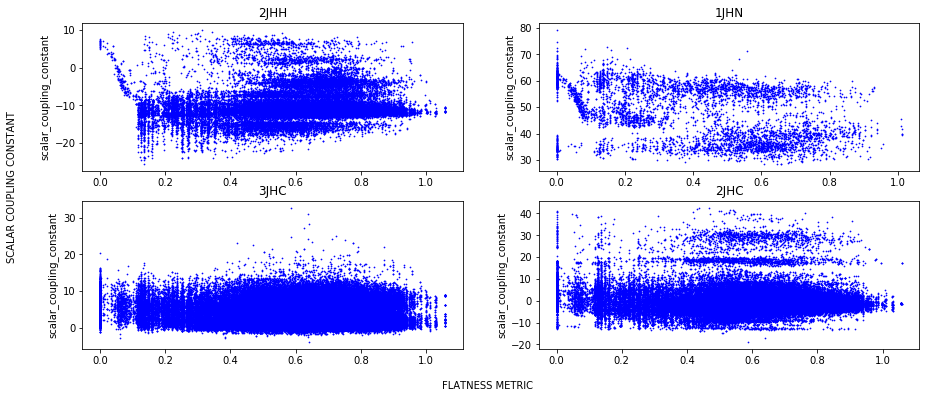

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (18, 6))
train.loc[train.type=='2JHH', :].plot(kind='scatter', x='flatness_metric', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[0, 0])
ax[0, 0].xaxis.set_label_text("")
ax[0, 0].set_title('2JHH')
train.loc[train.type=='1JHN', :].plot(kind='scatter', x='flatness_metric', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[0, 1])
ax[0, 1].xaxis.set_label_text("")
ax[0, 1].set_title('1JHN')
train.loc[train.type=='3JHC', :].plot(kind='scatter', x='flatness_metric', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[1, 0])
ax[1, 0].xaxis.set_label_text("")
ax[1, 0].set_title('3JHC')
train.loc[train.type=='2JHC', :].plot(kind='scatter', x='flatness_metric', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[1, 1])
ax[1, 1].xaxis.set_label_text("")
ax[1, 1].set_title('2JHC')
fig.text(0.5, 0.04, 'FLATNESS METRIC', ha='center', va='center')
fig.text(0.06, 0.5, 'SCALAR COUPLING CONSTANT', ha='center', va='center', rotation='vertical')
plt.show()

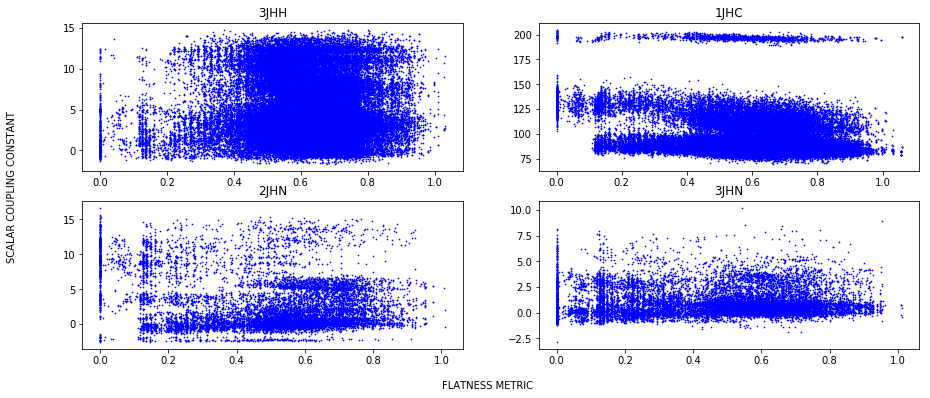

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (18, 6))
train.loc[train.type=='3JHH', :].plot(kind='scatter', x='flatness_metric', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[0, 0])
ax[0, 0].xaxis.set_label_text("")
ax[0, 0].yaxis.set_label_text("")
ax[0, 0].set_title('3JHH')
train.loc[train.type=='1JHC', :].plot(kind='scatter', x='flatness_metric', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[0, 1])
ax[0, 1].xaxis.set_label_text("")
ax[0, 1].yaxis.set_label_text("")
ax[0, 1].set_title('1JHC')
train.loc[train.type=='2JHN', :].plot(kind='scatter', x='flatness_metric', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[1, 0])
ax[1, 0].xaxis.set_label_text("")
ax[1, 0].yaxis.set_label_text("")
ax[1, 0].set_title('2JHN')
train.loc[train.type=='3JHN', :].plot(kind='scatter', x='flatness_metric', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[1, 1])
ax[1, 1].xaxis.set_label_text("")
ax[1, 1].yaxis.set_label_text("")
ax[1, 1].set_title('3JHN')
fig.text(0.5, 0.04, 'FLATNESS METRIC', ha='center', va='center')
fig.text(0.06, 0.5, 'SCALAR COUPLING CONSTANT', ha='center', va='center', rotation='vertical')
plt.show()

The flatness metric in isolation clearly isn't a strong feature, and could probably be improved by removing hydrogen bonds from its calculation. There are some aspects that might be useful, for example 2JHH and 1JHC bonds with a low flatness metric don't display high scalar coupling constants. 

## Bond Angle with Molecule Plane

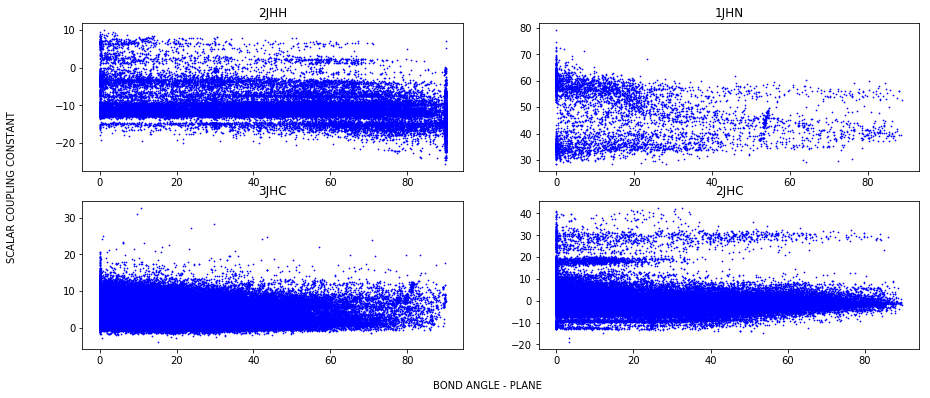

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (18, 6))
train.loc[train.type=='2JHH', :].plot(kind='scatter', x='bond_angle_plane', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[0, 0])
ax[0, 0].xaxis.set_label_text("")
ax[0, 0].yaxis.set_label_text("")
ax[0, 0].set_title('2JHH')
train.loc[train.type=='1JHN', :].plot(kind='scatter', x='bond_angle_plane', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[0, 1])
ax[0, 1].xaxis.set_label_text("")
ax[0, 1].yaxis.set_label_text("")
ax[0, 1].set_title('1JHN')
train.loc[train.type=='3JHC', :].plot(kind='scatter', x='bond_angle_plane', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[1, 0])
ax[1, 0].xaxis.set_label_text("")
ax[1, 0].yaxis.set_label_text("")
ax[1, 0].set_title('3JHC')
train.loc[train.type=='2JHC', :].plot(kind='scatter', x='bond_angle_plane', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[1, 1])
ax[1, 1].xaxis.set_label_text("")
ax[1, 1].yaxis.set_label_text("")
ax[1, 1].set_title('2JHC')
fig.text(0.5, 0.04, 'BOND ANGLE - PLANE', ha='center', va='center')
fig.text(0.06, 0.5, 'SCALAR COUPLING CONSTANT', ha='center', va='center', rotation='vertical')
plt.show()

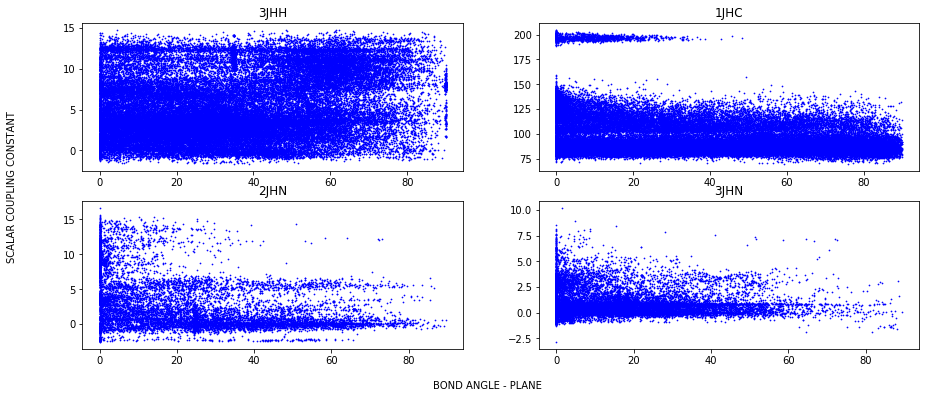

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (18, 6))
train.loc[train.type=='3JHH', :].plot(kind='scatter', x='bond_angle_plane', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[0, 0])
ax[0, 0].xaxis.set_label_text("")
ax[0, 0].yaxis.set_label_text("")
ax[0, 0].set_title('3JHH')
train.loc[train.type=='1JHC', :].plot(kind='scatter', x='bond_angle_plane', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[0, 1])
ax[0, 1].xaxis.set_label_text("")
ax[0, 1].yaxis.set_label_text("")
ax[0, 1].set_title('1JHC')
train.loc[train.type=='2JHN', :].plot(kind='scatter', x='bond_angle_plane', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[1, 0])
ax[1, 0].xaxis.set_label_text("")
ax[1, 0].yaxis.set_label_text("")
ax[1, 0].set_title('2JHN')
train.loc[train.type=='3JHN', :].plot(kind='scatter', x='bond_angle_plane', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[1, 1])
ax[1, 1].xaxis.set_label_text("")
ax[1, 1].yaxis.set_label_text("")
ax[1, 1].set_title('3JHN')
fig.text(0.5, 0.04, 'BOND ANGLE - PLANE', ha='center', va='center')
fig.text(0.06, 0.5, 'SCALAR COUPLING CONSTANT', ha='center', va='center', rotation='vertical')
plt.show()

These features look a lot stronger. 1JHC 2JHN and 3JHN bonds clearly show useful trends.

## Bond Angle with Molecule Principle Axis

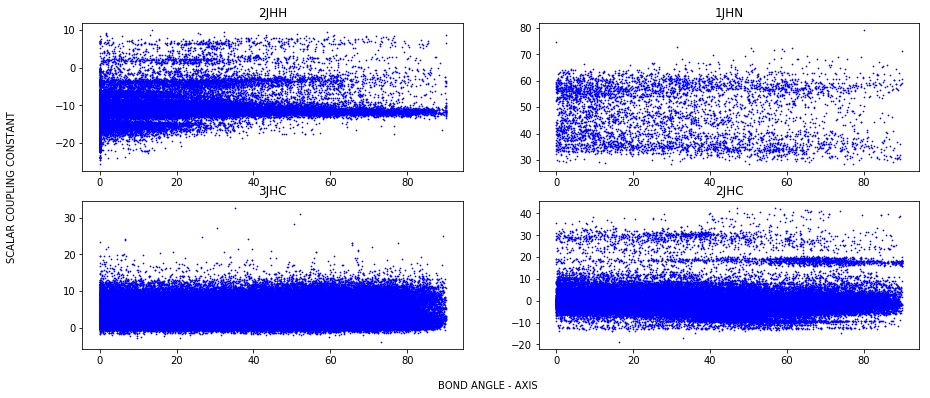

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (18, 6))
train.loc[train.type=='2JHH', :].plot(kind='scatter', x='bond_angle_axis', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[0, 0])
ax[0, 0].xaxis.set_label_text("")
ax[0, 0].yaxis.set_label_text("")
ax[0, 0].set_title('2JHH')
train.loc[train.type=='1JHN', :].plot(kind='scatter', x='bond_angle_axis', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[0, 1])
ax[0, 1].xaxis.set_label_text("")
ax[0, 1].yaxis.set_label_text("")
ax[0, 1].set_title('1JHN')
train.loc[train.type=='3JHC', :].plot(kind='scatter', x='bond_angle_axis', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[1, 0])
ax[1, 0].xaxis.set_label_text("")
ax[1, 0].yaxis.set_label_text("")
ax[1, 0].set_title('3JHC')
train.loc[train.type=='2JHC', :].plot(kind='scatter', x='bond_angle_axis', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[1, 1])
ax[1, 1].xaxis.set_label_text("")
ax[1, 1].yaxis.set_label_text("")
ax[1, 1].set_title('2JHC')
fig.text(0.5, 0.04, 'BOND ANGLE - AXIS', ha='center', va='center')
fig.text(0.06, 0.5, 'SCALAR COUPLING CONSTANT', ha='center', va='center', rotation='vertical')
plt.show()

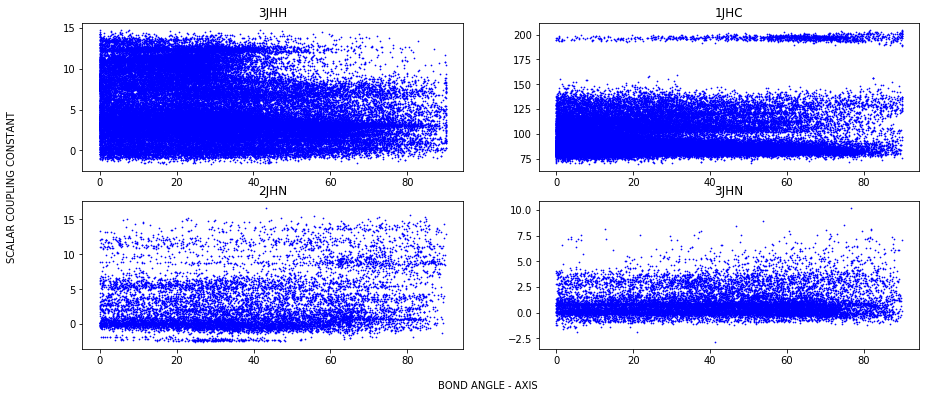

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (18, 6))
train.loc[train.type=='3JHH', :].plot(kind='scatter', x='bond_angle_axis', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[0, 0])
ax[0, 0].xaxis.set_label_text("")
ax[0, 0].yaxis.set_label_text("")
ax[0, 0].set_title('3JHH')
train.loc[train.type=='1JHC', :].plot(kind='scatter', x='bond_angle_axis', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[0, 1])
ax[0, 1].xaxis.set_label_text("")
ax[0, 1].yaxis.set_label_text("")
ax[0, 1].set_title('1JHC')
train.loc[train.type=='2JHN', :].plot(kind='scatter', x='bond_angle_axis', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[1, 0])
ax[1, 0].xaxis.set_label_text("")
ax[1, 0].yaxis.set_label_text("")
ax[1, 0].set_title('2JHN')
train.loc[train.type=='3JHN', :].plot(kind='scatter', x='bond_angle_axis', y='scalar_coupling_constant', color='b', figsize=(15, 6), s=0.5, ax=ax[1, 1])
ax[1, 1].xaxis.set_label_text("")
ax[1, 1].yaxis.set_label_text("")
ax[1, 1].set_title('3JHN')
fig.text(0.5, 0.04, 'BOND ANGLE - AXIS', ha='center', va='center')
fig.text(0.06, 0.5, 'SCALAR COUPLING CONSTANT', ha='center', va='center', rotation='vertical')
plt.show()

Again a mixed bag with a few areas that might benefit histogram splitting algorithms like LightGBM. 2JHH bonds for example show their lowest values with low bond-axis angle values. This is the weakest feature so far and I'll be working on improving it. There are undoubtedly many ways this approach can be extended with some more specific feature engineering but this kernel will hopefully be a useful primer to get you started.

Good luck in the competition!